In [ ]:
# Rekomendasi tuning dengan neural network
# Membuat rekomendasi berdasarkan rating yang sudah pernah dibuat oleh user
# yang selanjutnya dijadikan data training untuk 1 model.
# Model ini selanjutnya akan digunakan untuk memprediksi rating hotel sekitar user

In [ ]:
!pip install mysqlclient haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import sqlalchemy as sql_a
import tensorflow as tf

# Prepare Dataframe

In [ ]:
from ast import literal_eval
def evaluate_dataframe(df:pd.DataFrame) -> pd.DataFrame:
  for i in df.columns:
    if df.dtypes[i] == "O":
      try:
        df[i] = df[i].apply(literal_eval)
      except:
        print(f"Cannot evaluate {i}")

  return df

In [ ]:
# The data is not redundant
df_user = pd.read_sql("SELECT id, special_needs FROM Users", con=con)
df_user.dropna(inplace=True)
df_user = evaluate_dataframe(df_user)

def one_hot_special_needs(x):
  # x is pandas rows
  disability_list = ["tunadaksa", "tunawicara", "tunarungu", "tunanetra"]
  for i in disability_list:
    if i in x["special_needs"]:
      x[i] = 1
    else:
      x[i] = 0
  return x

df_user = df_user.apply(one_hot_special_needs, axis=1)
df_user.drop(columns=["special_needs"], inplace=True)
df_user.set_index("id", inplace=True)
df_user

,tunadaksa,tunawicara,tunarungu,tunanetra
id,,,,
1,0,0,0,0
2,0,0,1,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
...,...,...,...,...
110,0,0,0,0
114,0,1,0,0
117,0,0,0,0


In [ ]:
df_hotel = pd.read_sql("SELECT id, latitude, longitude, hotel_star, price_per_night, free_refund, nearby_destination, breakfast, pool, wifi, parking, smoking, air_conditioner, wheelchair_access, average_bed_size, staff_vaccinated, child_area FROM hotel_dummy_photos", con=con)
df_hotel.dropna(inplace=True)
df_hotel = evaluate_dataframe(df_hotel)
df_hotel[["free_refund", "breakfast","pool","wifi","parking","smoking","air_conditioner","wheelchair_access","average_bed_size","staff_vaccinated","child_area"]] = df_hotel[["free_refund", "breakfast","pool","wifi","parking","smoking","air_conditioner","wheelchair_access","average_bed_size","staff_vaccinated","child_area"]].astype(int)
df_hotel.set_index("id", inplace=True)
df_hotel
# Need to feature engineer

,latitude,longitude,hotel_star,price_per_night,free_refund,nearby_destination,breakfast,pool,wifi,parking,smoking,air_conditioner,wheelchair_access,average_bed_size,staff_vaccinated,child_area
id,,,,,,,,,,,,,,,,
1,-8.685925,115.165625,5.0,191,0,2,1,0,0,1,1,1,1,0,1,0
2,-8.693697,115.176362,4.5,258,0,2,0,0,0,1,1,1,0,0,1,0
3,-8.498648,115.259148,5.0,134,0,1,1,1,1,1,1,0,0,0,1,0
4,-8.665437,115.164076,5.0,118,0,4,0,0,1,1,0,1,0,0,1,1
5,-8.500065,115.250481,5.0,81,0,5,1,0,1,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-8.683299,115.159081,5.0,82,0,3,1,0,1,1,1,1,0,1,1,0
97,-8.666354,115.141334,4.5,278,0,3,1,0,1,1,0,1,0,0,1,0
98,-8.503381,115.241717,4.5,94,0,5,1,0,1,1,1,0,0,0,1,0


In [ ]:
df_review = pd.read_sql("SELECT hotel_id, user_id, rating FROM coba_review", con=con)
df_review.dropna(inplace=True)
df_review = evaluate_dataframe(df_review)
df_review = df_review.astype(int)
df_review

,hotel_id,user_id,rating
0,21,6,4
1,27,65,5
2,53,70,5
3,9,12,4
4,92,93,5
...,...,...,...
9853,11,68,2
9854,11,68,2
9855,11,68,2
9856,11,68,2


In [ ]:
print("Hotel features: ", len(df_hotel.columns))
print("User features: ", len(df_user.columns))

Hotel features:  15
User features:  5


# Test Modelling

In [ ]:
# Train base model
# We need to train based on hotel feature
# And output a rating

In [ ]:
tf.keras.backend.clear_session()
def create_model():
  user_input = tf.keras.Input(shape=(4),)
  hotel_input = tf.keras.Input(shape=(14),)
  x = tf.keras.layers.Concatenate(axis=-1)([user_input, hotel_input])
  x = tf.keras.layers.Dense(128, activation="relu")(x)
  x = tf.keras.layers.Dense(64, activation="relu")(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  output = tf.keras.layers.Dense(units=1)(x)

  model = tf.keras.Model(inputs=[user_input, hotel_input], outputs=output)
  model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mean_absolute_error"])
  return model

model = create_model()

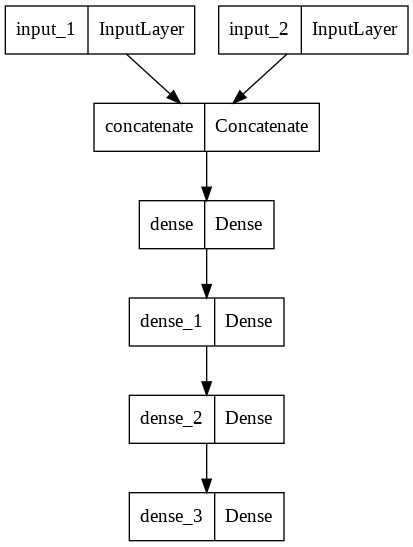

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 18)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          2432        ['concatenate[0][0]']        

In [ ]:
# https://errorsfixing.com/valueerror-data-cardinality-is-ambiguous-please-provide-data-which-shares-the-same-first-dimension/

import numpy as np
a = tf.convert_to_tensor(np.array([0 for _ in range(4)]).reshape(1,-1))
b = tf.convert_to_tensor(np.array([1 for _ in range(14)]).reshape(1,-1))

In [ ]:
a

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[0, 0, 0, 0]])>

In [ ]:
model([a,b])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.01360693]], dtype=float32)>

# Creating "Pre-Train" Model

In [ ]:
# Create data from all reviews 
user_attr = []
hotel_attr = []
rating = []

for index, row in df_review.iterrows():
  hotel_id = row["hotel_id"]
  user_id = row["user_id"]
  rating.append(row["rating"])
  user_attr.append(df_user.loc[user_id].values)
  hotel_attr.append(df_hotel.loc[hotel_id].values)

user_attr = tf.convert_to_tensor(user_attr)
hotel_attr = tf.convert_to_tensor(hotel_attr)
rating = tf.convert_to_tensor(rating)

In [ ]:
print(user_attr)
print(hotel_attr)
print(rating)

tf.Tensor(
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 1]], shape=(9858, 4), dtype=int32)
tf.Tensor(
[[  4.   57.    0.  ...   0.    1.    0. ]
 [  5.  187.    0.  ...   0.    1.    0. ]
 [  4.5 148.    0.  ...   0.    1.    1. ]
 ...
 [  5.   37.    0.  ...   0.    1.    0. ]
 [  5.   37.    0.  ...   0.    1.    0. ]
 [  4.5 262.    0.  ...   0.    1.    0. ]], shape=(9858, 14), dtype=float64)
tf.Tensor([4 5 5 ... 2 2 4], shape=(9858,), dtype=int32)


In [ ]:
# Create Model
model = create_model()
# Testing
model.predict([user_attr[:1, :], hotel_attr[:1, :]])

array([[-4.4112716]], dtype=float32)

In [ ]:
# Train
x = [user_attr, hotel_attr]
y = rating
model.fit(x, y, validation_split=0.2, batch_size=32, epochs=200)

Epoch 1/200
247/247 [==============================] - 1s 5ms/step - loss: 1.1818 - mean_absolute_error: 1.1818 - val_loss: 1.2061 - val_mean_absolute_error: 1.2061
Epoch 2/200
247/247 [==============================] - 1s 5ms/step - loss: 1.1860 - mean_absolute_error: 1.1860 - val_loss: 1.2175 - val_mean_absolute_error: 1.2175
Epoch 3/200
247/247 [==============================] - 1s 3ms/step - loss: 1.1842 - mean_absolute_error: 1.1842 - val_loss: 1.2209 - val_mean_absolute_error: 1.2209
Epoch 4/200
247/247 [==============================] - 1s 3ms/step - loss: 1.1817 - mean_absolute_error: 1.1817 - val_loss: 1.2055 - val_mean_absolute_error: 1.2055
Epoch 5/200
247/247 [==============================] - 1s 2ms/step - loss: 1.1813 - mean_absolute_error: 1.1813 - val_loss: 1.2301 - val_mean_absolute_error: 1.2301
Epoch 6/200
247/247 [==============================] - 1s 3ms/step - loss: 1.1821 - mean_absolute_error: 1.1821 - val_loss: 1.2118 - val_mean_absolute_error: 1.2118
Epoch 7/20

In [ ]:
model.save("./test_save")

INFO:tensorflow:Assets written to: ./test_save/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save("/content/drive/Shareddrives/CapBatu/ML Divsion/For Your Recommendation/models/v1/saved_model")

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/CapBatu/ML Divsion/For Your Recommendation/models/v1/saved_model/assets


In [ ]:
saved_model_path = "/content/drive/Shareddrives/CapBatu/ML Divsion/For Your Recommendation/models/v1/saved_model" # The last one should be "/saved_model"
out_zip_path = "/content/drive/Shareddrives/CapBatu/ML Divsion/For Your Recommendation/models/v1/v1.zip" # With .zip extension

In [ ]:
!cp -r "{saved_model_path}" "./" && zip -Z bzip2 -r "{out_zip_path}" "./saved_model" && rm -fr "saved_model"

  adding: saved_model/ (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/saved_model.pb (bzipped 90%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (bzipped 57%)
  adding: saved_model/variables/variables.data-00000-of-00001 (bzipped 47%)
  adding: saved_model/keras_metadata.pb (bzipped 88%)


In [ ]:
original_model = model

In [ ]:
# "Pre Train Model Done..."
# Now Let's try to make the pipeline

# Input (user_id, longitude, latitude)
# Check if the user is already have the review enough to "train" the model (10 reviews minimum)

# Get all the reviews the user have trained
# Train the models

# Get 10 closest hotel user
# Predict those 10 closest hotel based on user models

In [ ]:
from typing import Union
def user_enough_review(minimum_reviews:int, user_id: int, df: pd.DataFrame) -> Union[pd.DataFrame, None]:
  """
  Get Users Reviews. If less than minimum_reviews returns 0. 
  If not will return the reviews dataframe contains user_id, hotel_id, rating
  """
  df_temp = df[df["user_id"] == user_id]
  if len(df_temp) < minimum_reviews:
    return None
  return df_temp

user_enough_review(10, 117, df_review)

In [ ]:
def create_training_data(training_review, df_hotel, df_user):
  """
  training_review : dataframe[hotel_id, user_id, rating]
  df_hotel : dataframe["hotel attributes"] -> must have 14 attr
  df_user : dataframe["user attributes"] -> must have 4 attr

  Create Training tensor based on hotel_id, user_id lookups to hotel dataframe
  and user dataframe as feature and targets a rating in training_review dataframe
  """
  user_attr = []
  hotel_attr = []
  rating = []

  for index, row in training_review.iterrows():
    hotel_id = row["hotel_id"]
    user_id = row["user_id"]
    rating.append(row["rating"])
    user_attr.append(df_user.loc[user_id].values)
    hotel_attr.append(df_hotel.loc[hotel_id].values)

  user_attr = tf.convert_to_tensor(user_attr)
  hotel_attr = tf.convert_to_tensor(hotel_attr)
  rating = tf.convert_to_tensor(rating)

  return user_attr, hotel_attr, rating

In [ ]:
import haversine as hs

def closest_hotel_id(num: int, longitude, latitude, df_hotel_in) -> np.ndarray:
  """
  df_hotel_in : dataframe[longitude, latitude]
  Gives (num) hotel ids based on longitude and latitude inputs
  """
  df_hotel = df_hotel_in.copy()
  user = (latitude, longitude)
  df_hotel["coordinate"] = list(zip(df_hotel["latitude"], df_hotel["longitude"]))
  df_hotel["distance_to_user"] = df_hotel["coordinate"].apply(lambda x: hs.haversine(user, x))
  df_hotel = df_hotel.sort_values(by=["distance_to_user"])
  return df_hotel.head(num).index.values

In [ ]:
df_hotel.head(2)

,latitude,longitude,hotel_star,price_per_night,free_refund,nearby_destination,breakfast,pool,wifi,parking,smoking,air_conditioner,wheelchair_access,average_bed_size,staff_vaccinated,child_area
id,,,,,,,,,,,,,,,,
1,-8.685925,115.165625,5.0,191,0,2,1,0,0,1,1,1,1,0,1,0
2,-8.693697,115.176362,4.5,258,0,2,0,0,0,1,1,1,0,0,1,0


In [ ]:
df_review.head(2)

,hotel_id,user_id,rating
0,21,6,4
1,27,65,5


In [ ]:
df_user.head(2)

,tunadaksa,tunawicara,tunarungu,tunanetra
id,,,,
1,0,0,0,0
2,0,0,1,0


In [ ]:
# Dont forget load review dataframe, hotel dataframe and user dataframe
# and preprocessed them.

# Also load the "pre-train" model

def pipelines(num_recs, user_id, longitude, latitude):
  if user_id not in df_user.index:
    return "User ID not available or not cached yet"

  hotel_train_items = ["hotel_star", "price_per_night", "free_refund", 
              "nearby_destination", "breakfast", "pool", "wifi", "parking", 
              "smoking", "air_conditioner", "wheelchair_access", 
              "average_bed_size", "staff_vaccinated", "child_area"]

  df_hotel_attr = df_hotel.filter(items=hotel_train_items).copy()
  # Check if the user is already have the review enough to "train" the model (10 reviews minimum)
  training_review = user_enough_review(10, user_id, df_review)
  if training_review is None:
    return "Not Enough Review"
  
  # Get all the reviews the user have trained
  # Train the models
  user_attr, hotel_attr, rating = create_training_data(training_review, 
                                                       df_hotel_attr, df_user)
  non_original_model = create_model() 
  non_original_model.set_weights(original_model.get_weights())
  non_original_model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mean_absolute_error"])
  non_original_model.fit([user_attr, hotel_attr], rating, epochs=10, verbose=0)

  # Get 10 closest hotel user
  # Predict those 10 closest hotel based on user models
  hotel_predict_ids = closest_hotel_id(num_recs, longitude, latitude, df_hotel)
  hotel_predict = df_hotel_attr.loc[hotel_predict_ids].values
  hotel_predict = tf.convert_to_tensor(hotel_predict)
  user_predict = tf.convert_to_tensor([user_attr[0] for _ in range(num_recs)])

  prediction = non_original_model.predict([user_predict, hotel_predict])
  prediction = prediction.reshape(1, -1)[0]
  prediction = np.argsort(prediction)[::-1]
  
  final_recs = []
  for i in prediction:
    final_recs.append(int(hotel_predict_ids[i]))

  return final_recs

In [ ]:
%%time
pipelines(num_recs=15, user_id=100, longitude=99, latitude=10)

CPU times: user 1.07 s, sys: 19.7 ms, total: 1.09 s
Wall time: 1.28 s


[3, 36, 99, 98, 50, 83, 59, 30, 46, 5, 23, 44, 35, 18, 81]